# Problem statement
<p><font size="3px">From a image low resolution reconstruct a higher quality one. Many Conventional algorithms exist which do this exact task but with only limited success. The amount of information contained in the given image is limited and in a lot of examples not enough to reconstruct a better quality one without guessing. Therefore, each low-resolution pixel has a multiplicity of solutions and this problem becomes generative.</font></p>
# Previous research
These types of algorithms are called super resolution and the specific branch I'll be addressing is called SRCNN because it utilizes Convolutional Neural Networks. It has been widely researched in the past:<br/>
<a href="http://personal.ie.cuhk.edu.hk/~ccloy/files/eccv_2014_deepresolution.pdf">Learning a Deep Convolutional Network for Image Super-Resolution
 2014 </a> <br/>
 <a href="https://arxiv.org/pdf/1501.00092.pdf">Image Super-Resolution Using Deep
Convolutional Networks 2015</a><br/>
<a href="https://arxiv.org/abs/1609.04802">Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network</a>
<br/>are the latest additions.

# New Section

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras_contrib.losses import DSSIMObjective

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-2mkt_3wn
  Running setup.py bdist_wheel for keras-contrib ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-g8_ckesh/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


Using TensorFlow backend.


In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure


from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf

from tensorflow.keras import Model
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential,load_model
from tensorflow.python.keras.layers import Activation, InputLayer, Layer, Conv2D,Conv2DTranspose, UpSampling2D, \
    MaxPool2D, Dense, Dropout, Flatten, Reshape, Input, BatchNormalization, LeakyReLU, concatenate
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.generic_utils import get_custom_objects
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.utils import plot_model

import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import random
import pickle
import cv2
import math
import PIL.Image

In [0]:
K.clear_session()
tf.reset_default_graph()

# Dataset
I used the <a href="https://cs.stanford.edu/~acoates/stl10/">stl10</a> dataset because it had a fair amount of low resolution images which were not too closely related to eachother. For a more serious project the imagenet dataset would definitely improve the results acquired here.

In [0]:
from zipfile import ZipFile
with ZipFile('gdrive/My Drive/stl.zip', 'r') as zf:
    zf.extractall('./')

In [0]:
import os

path, dirs, files = next(os.walk("stl10-dataset"))
file_count = len(files)
print("num files: ", file_count)

num files:  113000


In [0]:
!pip install imutils
from imutils import paths

In [0]:
imagePaths = sorted(list(paths.list_images('stl10-dataset/')))

random.seed(42)
random.shuffle(imagePaths)

width, height = 48,48

<font size="3">The get batch function returns a portion of the whole dataset. I used it bacase the ram in google colab is pretty limited and loading the whole dataset was too much to handle. It returns 10000 images 48x48 and 10000 which are 96x96 - the input and desired output</font>

In [0]:
def getBatch(batchNum = 0, normalize = True):
    print("[INFO] loading batch {} ...".format(batchNum+1))
    if(batchNum>int(len(imagePaths)/10000)):
      batchNum %= int((len(imagePaths)/10000)-1)
      batchNum +=1 #excluding the val set which is batch 0
    
    data = []
    dataBig = []

    for imagePath in imagePaths[batchNum*10000:(batchNum+1)*10000]:
        image = cv2.imread(imagePath)
        if(image.shape[0] < width*2):
            continue
        if(image.shape[1] < height*2):
            continue
        dataBig.append(cv2.resize(image, (width*2, height*2)))
        data.append(cv2.resize(image, (width, height)))
    
    if(normalize):
      data = np.array(data, dtype="float32")/255.
      dataBig = np.array(dataBig, dtype="float32")/255.
    else:
      data = np.array(data, dtype="float32")
      dataBig = np.array(dataBig, dtype="float32") 
    return (data,dataBig)

<font size="3">I added the - in front of the function so that the optimiser minimizes it correctly.

In [0]:
def psnr(target, ref):
  return -tf.image.psnr(target,ref,255)

<font size="3">A custom layer for scaling the images up by a factor of two. It uses bicubic interpolation which is considered the current best conventional resizing method.</font>

In [0]:
class ImageRescale(Layer):
    def __init__(self, scale, method=tf.image.ResizeMethod.BICUBIC,
                 trainable=False, **kwargs):
        self.scale = scale
        self.method = method
        super().__init__(trainable=trainable, **kwargs)

    def compute_size(self, shape):
        if(shape[1]==None and shape[2]==None):
          return (1,1)
        size = np.array(shape)[[1, 2]] * self.scale
        return tuple(size.astype(int))

    def call(self, x):
        print('shape: ', x.shape.as_list())
        size = self.compute_size(x.shape.as_list())
        return tf.image.resize_images(x, size, method=self.method)

    def compute_output_shape(self, input_shape):
        size = self.compute_size(input_shape)
        return (input_shape[0], *size, input_shape[3])
  
    def get_config(self):
        config = super().get_config()
        config['scale'] = self.scale
        config['method'] = self.method
        return config

<font size="3"> This is a little function I made which just kept getting bigger and bigger and in the end it became this jumbled mess it is right now but I am too lazy to fix it. It trains the given model for a specified amount of time and it shows some statistic after each epoch. You can also specify a variety of other things.</font>

In [0]:
def TrainModelFor(EPOCHS, model, name,INIT_LR = 0.0005, normalize = True, compile_model=False, minibatch=64, prevHistory ={}):
  print("[INFO] training network...")
  if(compile_model):
    opt = Adam(lr=INIT_LR,beta_1=0.9)
    model.compile(loss=tf.losses.mean_squared_error, optimizer=opt,
      metrics=["accuracy", DSSIMObjective(), psnr])
  testX, testY = getBatch(0, normalize)
  
  history = dict(prevHistory)
  for i in range(1, EPOCHS+1):
      trainX, trainY = getBatch(i,normalize)
      H = model.fit(trainX, trainY, validation_data=(testX[0:2048], testY[0:2048]), epochs=1, batch_size=minibatch)#the other 8000 images are for testing

      for key, value in H.history.items():
        if(not key in history):history[key]=[]
        history[key] += value
      
      model.save('gdrive/My Drive/{}.h5'.format(name))
      fig = plt.figure(figsize=(1, 3), dpi=800)
      
      out = np.array(testX[0])
      if(normalize):out = np.array(testX[0])*255
      out = np.array(cv2.resize(out, dsize=(width*2,height*2), interpolation = cv2.INTER_CUBIC))
      out = np.clip(out, 0, 255)
      img = PIL.Image.fromarray(out.astype('uint8'))
      fig.add_subplot(1, 3, 1)
      plt.imshow(img)
      plt.axis('off')

      out = np.array(model.predict(np.array([testX[0]])))[0]
      if(normalize):out*=255
      out = np.clip(out, 0, 255)
      img = PIL.Image.fromarray(out.astype('uint8'))
      fig.add_subplot(1, 3, 2)
      plt.imshow(img)
      plt.axis('off')
      
      out = testY[0]
      if(normalize):out = testY[0]*255
      out = np.clip(out, 0, 255)
      img = PIL.Image.fromarray(out.astype('uint8'))
      fig.add_subplot(1, 3, 3)
      plt.imshow(img)
      plt.axis('off')
      
      if(not history):
        continue
      plt.figure(2)
      plt.subplot(221)
      plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.6, hspace=0.6)
      plt.plot(history['acc'])
      plt.plot(history['val_acc'])
      plt.title('accuracy higher=better')
      plt.ylabel('accuracy')
      plt.xlabel('epoch')
      plt.legend(['train', 'test'], loc='upper left')
      
      plt.subplot(222)
      plt.plot(history['loss'])
      plt.plot(history['val_loss'])
      plt.title('loss lower=better')
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.legend(['train', 'test'], loc='upper left')
      
      plt.subplot(223)
      plt.plot(history['DSSIMObjective'])
      plt.plot(history['val_DSSIMObjective'])
      plt.title('DSSIM lower=better')
      plt.ylabel('DSSIM')
      plt.xlabel('epoch')
      plt.legend(['train', 'test'], loc='upper left')
      
      plt.subplot(224)
      plt.plot(history['psnr'])
      plt.plot(history['val_psnr'])
      plt.title('psnr lower=better')
      plt.ylabel('dB')
      plt.xlabel('epoch')
      plt.legend(['train', 'test'], loc='upper left')

      plt.savefig('gdrive/My Drive/plot{}.pdf'.format(name))
      plt.show()
  return history;

# Models

<h1>A shallow resnet variant of the typical SRCNN</h1>
<font size="3">It was my first attempt and it didn't turn out as well as I had hoped. The first thing I would change about it would be to add batch normalization after each activation and also remove the rescale output from the concatenation because I suspect that it hinders it more than it helps it as it allows it to somewhat 'cheat'.</font>

In [0]:
#Shallow resnet
def customModel():
    
    inputs = Input(shape=(width,height,3))
    rescale = ImageRescale(scale=2, method=tf.image.ResizeMethod.BICUBIC)(inputs)
    
    conv1 = Conv2D(64, 9, padding='same', kernel_initializer='he_normal')(rescale)
    act1 = LeakyReLU(alpha=0.3)(conv1)
    
    conv2 = Conv2D(64, 5, padding='same', kernel_initializer='he_normal')(act1)
    act2 = LeakyReLU(alpha=0.3)(conv2)
    
    conv3 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(act2)
    act3 = LeakyReLU(alpha=0.3)(conv3)
    
    merge1 = concatenate([act3, act2, act1, rescale], axis=3)
    
    output = Conv2D(3, 3, padding='same')(merge1)
    
    model = Model(inputs=[inputs],outputs=[output])
    
    return model

shape:  [None, 48, 48, 3]


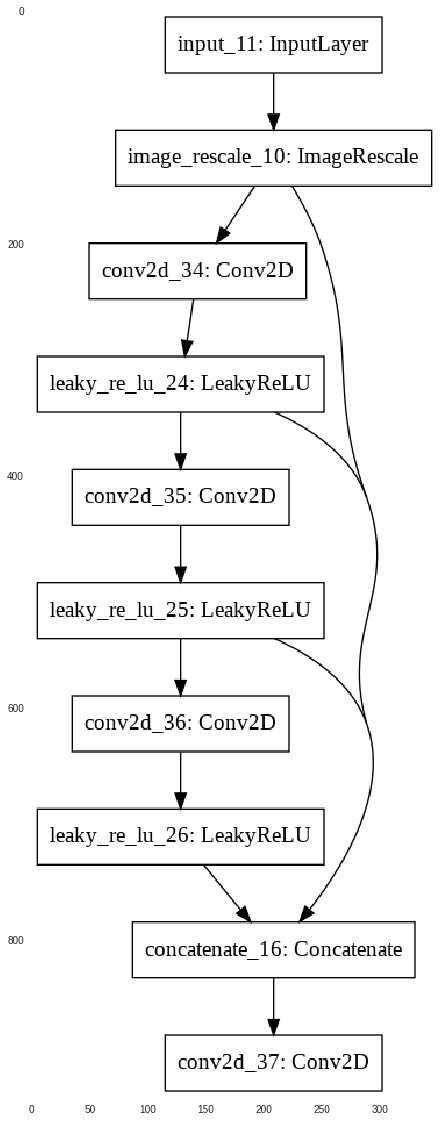

In [0]:
model = customModel()
plot_model(model, to_file='model.png')
img=mpimg.imread('model.png')
plt.figure(figsize=(20,20))
plt.grid(False)
plt.imshow(img)
del model

In [0]:
session1 = tf.Session()
with session1.as_default():
  K.set_session(session1)
  model_new = customModel()
  TrainModelFor(100, model_new,'model1.0',0.0002,False,True)
  K.clear_session()
session1.close()
del model_new

Output hidden; open in https://colab.research.google.com to view.

<font size="3">The colors are a little off and it's still pretty blocky. I would classify that model as a failure although the training loss curve shows that it could probably improve a little bit more.</font>

<h1>Dense SRCNN</h1>
<font size="3">This is another variant of the typical SRCNN but this time I made it dense, removed the rescale output from the second concat and added batchnorm but before the activation as many suggest it gives better results.</font>

In [0]:
#super shallow densenet
def customModel2():
    inputs = Input(shape=(width,height,3))
    rescale = ImageRescale(scale=2, method=tf.image.ResizeMethod.BICUBIC)(inputs)
    
    conv1 = Conv2D(64, 9, padding='same', kernel_initializer='he_normal')(rescale)
    bn1 = BatchNormalization()(conv1)
    act1 = LeakyReLU(alpha=0.2)(bn1)
    
    merge1 = concatenate([act1, rescale], axis=3)
   
    conv2 = Conv2D(32, 5, padding='same', kernel_initializer='he_normal')(merge1)
    bn2 = BatchNormalization()(conv2)
    act2 = LeakyReLU(alpha=0.2)(bn2)
    
    merge2 = concatenate([act2, act1], axis=3)
    
    output = Conv2D(3, 5, padding='same', activation='linear')(merge2)
    
    model = Model(inputs=[inputs],outputs=[output])
    return model

shape:  [None, 48, 48, 3]


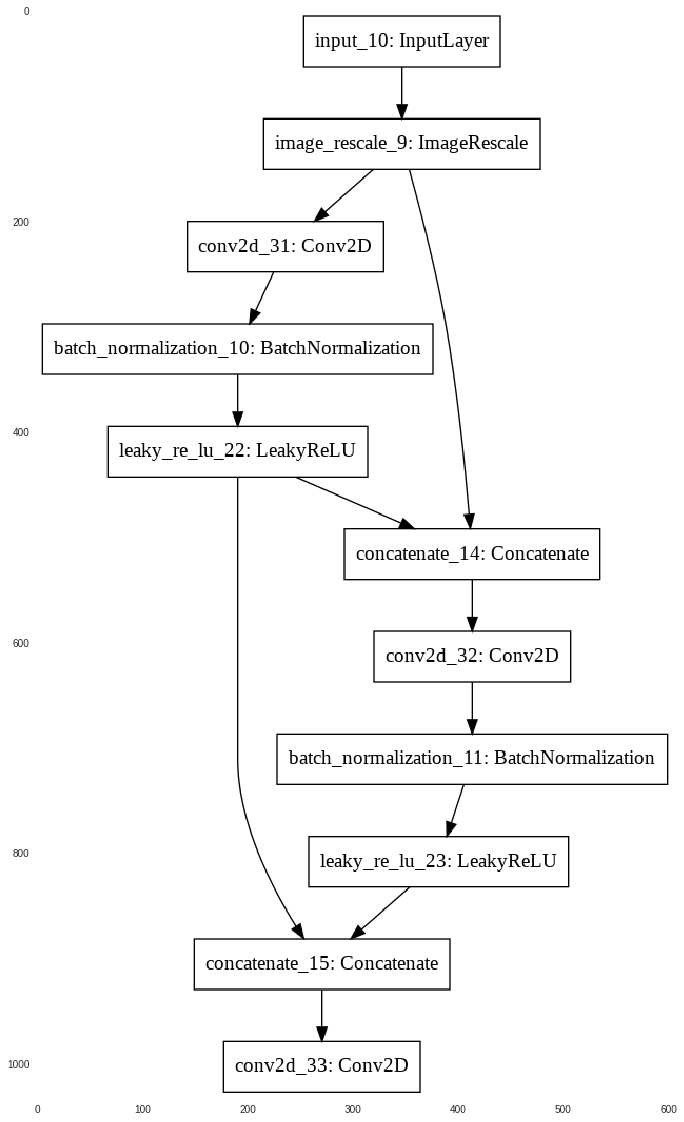

In [0]:
model2 = customModel2()
plot_model(model2, to_file='model.png')
img=mpimg.imread('model.png')
plt.figure(figsize=(20,20))
plt.grid(False)
plt.imshow(img)
del model2

In [0]:
session2 = tf.Session()
with session2.as_default():
  K.set_session(session2)
  #model_new = customModel2()
  model_new = load_model('gdrive/My Drive/model2.2.h5',{'ImageRescale':ImageRescale, 'psnr':psnr, 'DSSIMObjective':DSSIMObjective()})
  TrainModelFor(50, model_new,'model2.2',0.01,False,True,128)
  K.clear_session()
session2.close()
del model_new

Output hidden; open in https://colab.research.google.com to view.

<font size = "3">The learning rate was definitely too high. I'll try with a lower one.</font>



In [0]:
session2 = tf.Session()
with session2.as_default():
  K.set_session(session2)
  #model_new = customModel2()
  model_new = load_model('gdrive/My Drive/model2.2.h5',{'ImageRescale':ImageRescale, 'psnr':psnr, 'DSSIMObjective':DSSIMObjective()})
  TrainModelFor(50, model_new,'model2.2',0.0005,False,True,128)
  K.clear_session()
session2.close()
del model_new

Output hidden; open in https://colab.research.google.com to view.

<font size = "3">I guess it was not the learning rate then. Although there was a slight jump in the loss function it stopped improving pretty fast. The model is just weak, which is definitely weird considering that it is just a slightly modified version of the classic SRCNN. My guess is that MSE is probably just not that good of a cost function for this problem or that batchnormalization somehow breaks this particular model..? I have no idea. </font>

<h1>Inception SRCNN</h1>
<font size="3">Ok enough with the baby shit. This model copies google's initial inception model but since this problem is a little different from your typical image classification, I fear that the features extracted by VGG or Inception would not work here. This is in its core a noise reduction problem and so another model for noise reduction would work better for transfer learning(note for future research).

In [0]:
#InceptionBlocked
def customModel3():
    inputs = Input(shape=(width,height,3))
    rescale = ImageRescale(scale=2, method=tf.image.ResizeMethod.BICUBIC)(inputs)
    
    conv1_1 = Conv2D(64, (1,1), padding='same', activation='relu')(rescale)
    conv1_1 = Conv2D(64, (3,3), padding='same', activation='relu')(conv1_1)
    conv1_1 = BatchNormalization()(conv1_1)
    
    conv2_1 = Conv2D(64, (1,1), padding='same', activation='relu')(rescale)
    conv2_1 = Conv2D(64, (5,5), padding='same', activation='relu')(conv2_1)
    conv2_1 = BatchNormalization()(conv2_1)
    
    conv3_1 = MaxPool2D((3,3), strides=(1,1), padding='same')(rescale)
    conv3_1 = Conv2D(64, (1,1), padding='same', activation='relu')(conv3_1)
    conv3_1 = BatchNormalization()(conv3_1)
    
    conv4_1 = Conv2D(64, (1,1), padding='same', activation='relu')(rescale)
    conv4_1 = BatchNormalization()(conv4_1)
    
    output1 = concatenate([conv1_1, conv2_1, conv3_1, conv4_1], axis = 3)
    
    #------------------------------------------------------------------#
    
    conv1_2 = Conv2D(32, (1,1), padding='same', activation='relu')(output1)
    conv1_2 = Conv2D(64, (3,3), padding='same', activation='relu')(conv1_2)
    conv1_2 = BatchNormalization()(conv1_2)
    
    conv2_2 = Conv2D(32, (1,1), padding='same', activation='relu')(output1)
    conv2_2 = Conv2D(64, (5,5), padding='same', activation='relu')(conv2_2)
    conv2_2 = BatchNormalization()(conv2_2)
    
    conv3_2 = MaxPool2D((3,3), strides=(1,1), padding='same')(output1)
    conv3_2 = Conv2D(32, (1,1), padding='same', activation='relu')(conv3_2)
    conv3_2 = BatchNormalization()(conv3_2)
    
    conv4_2 = Conv2D(32, (1,1), padding='same', activation='relu')(output1)
    conv4_2 = BatchNormalization()(conv4_2)
    
    output2 = concatenate([conv1_2, conv2_2, conv3_2, conv4_2], axis = 3)
    reduced = Conv2D(64, (1,1), padding='same', activation='relu')(output2)
    
    output = Conv2D(3, 3, padding='same')(reduced)
    
    model = Model(inputs=[inputs],outputs=[output])
    
    return model

shape:  [None, 48, 48, 3]


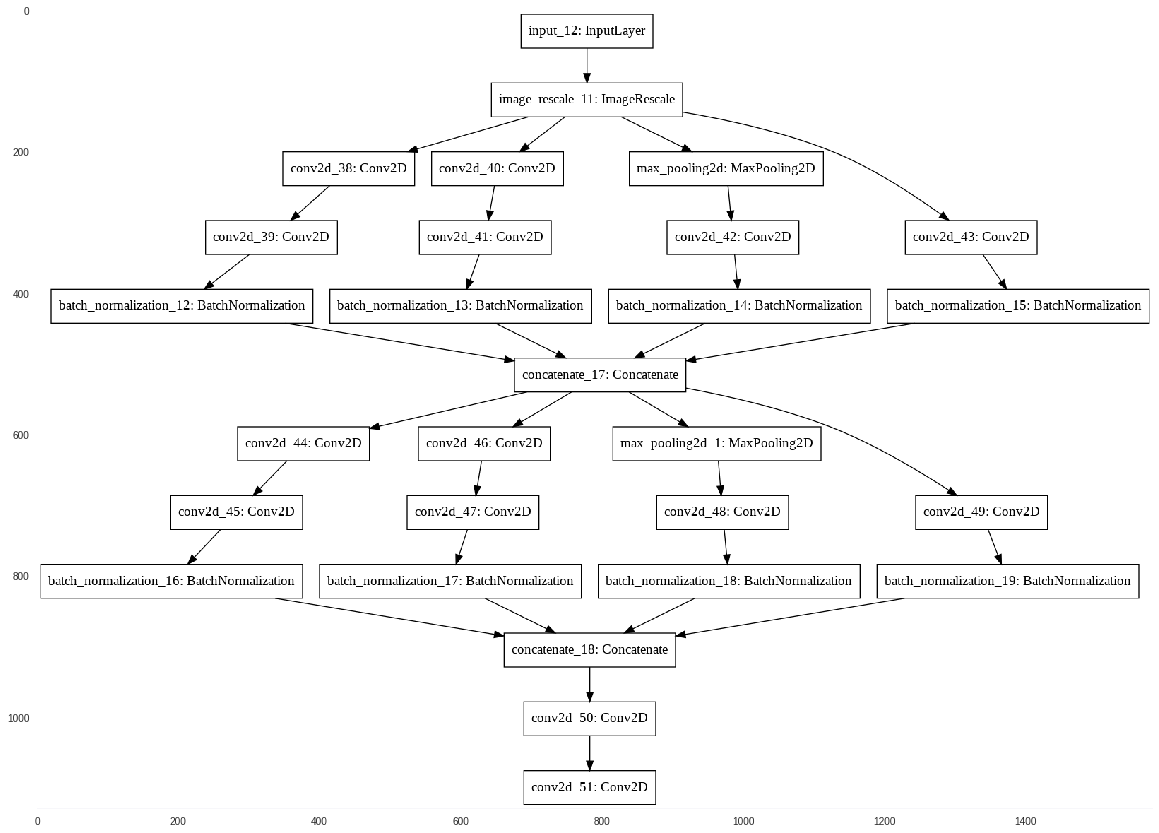

In [0]:
model3 = customModel3()
plot_model(model3, to_file='model3.png')
img=mpimg.imread('model3.png')
plt.figure(figsize=(20,20))
plt.grid(False)
plt.imshow(img)
del model3

<p><font size="4">Ok the deadline is incredibly close. Time to cheat.<br/> <b>Stage one:</b> Train an inception-like model with only two layers.</font></p>

In [0]:
session3 = tf.Session()
with session3.as_default():
  K.set_session(session3)
  model = load_model('gdrive/My Drive/model3.1.h5',{'ImageRescale':ImageRescale, 'psnr':psnr, 'DSSIMObjective':DSSIMObjective()})
  #model = customModel3()
  #TrainModelFor(40,model,'model3.1',0.01,False)
  #TrainModelFor(50,model,'model3.1',0.001,False)
  TrainModelFor(40,model,'model3.1',0.0005,False,False,32)
  K.clear_session()
del model
session3.close()

Output hidden; open in https://colab.research.google.com to view.

<font size="3pt">Pretty good results. There's definitely an improvement over the initial image (Bicubic), but still nowhere near the results I was hoping for. I should definitely train it for longer in the future and try a bigger dataset like imagenet. Also I think I made a mistake making the convolution filters 5 and 3 in the first block. I should have made them bigger as it was proven empirically in the above papers that bigger filters perform better.</font>

<p><font size="3pt"><b>Stage two:</b> Just repeat the already trained inception blocks a couple of times and hope for the best. I'll also make the first part of the algorithm untrainable it would take too long to train such a big model otherwise. I will also have to reduce the minibatch size as the GPU memory in google colab is limited.</font></p>

shape:  [None, 48, 48, 3]
shape:  [None, 48, 48, 3]


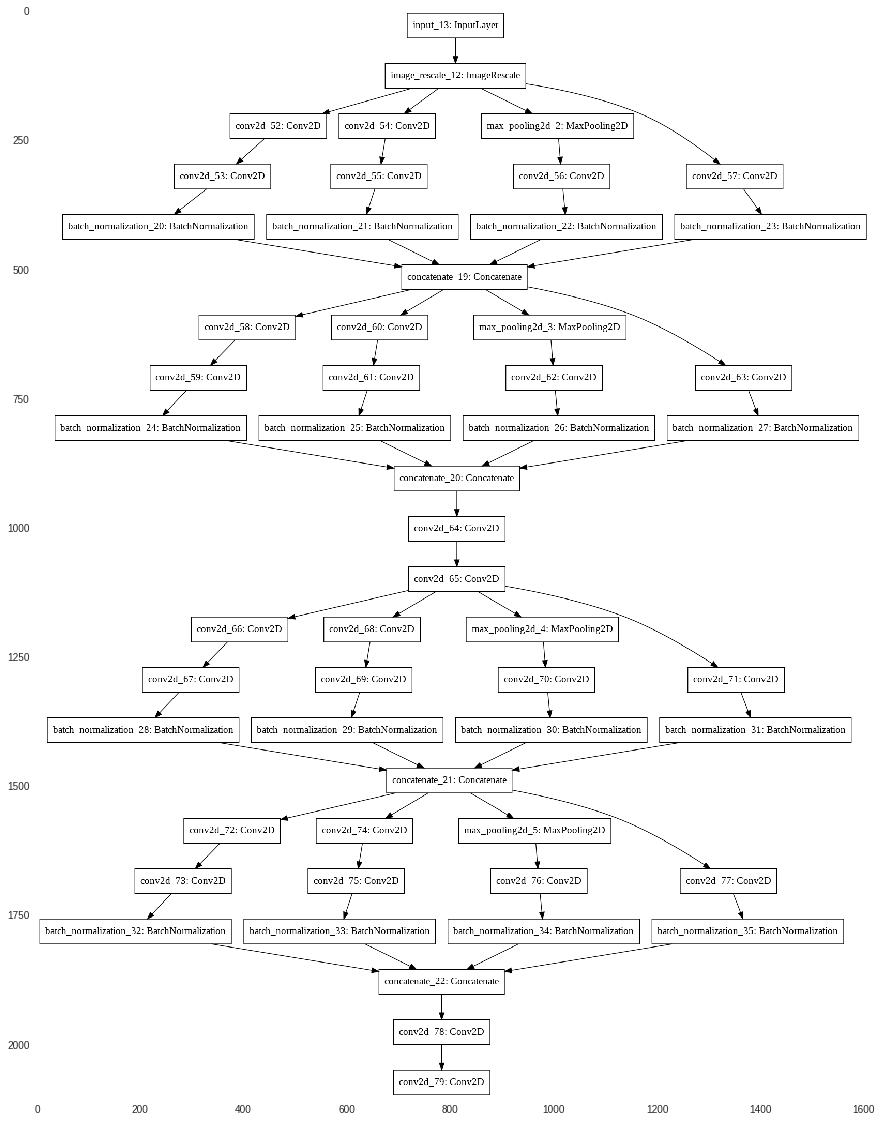

In [0]:
session3 = tf.Session()
with session3.as_default():
    K.set_session(session3)
    model_trained = load_model('gdrive/My Drive/model3.1.h5',{'ImageRescale':ImageRescale, 'psnr':psnr, 'DSSIMObjective':DSSIMObjective()})
    
    inputs = Input(shape=(width,height,3))
    rescale = ImageRescale(scale=2, method=tf.image.ResizeMethod.BICUBIC)(inputs)

    conv1_1 = Conv2D(64, (1,1), padding='same', activation='relu')(rescale)
    conv1_1 = Conv2D(64, (3,3), padding='same', activation='relu')(conv1_1)
    conv1_1 = BatchNormalization()(conv1_1)

    conv2_1 = Conv2D(64, (1,1), padding='same', activation='relu')(rescale)
    conv2_1 = Conv2D(64, (5,5), padding='same', activation='relu')(conv2_1)
    conv2_1 = BatchNormalization()(conv2_1)

    conv3_1 = MaxPool2D((3,3), strides=(1,1), padding='same')(rescale)
    conv3_1 = Conv2D(64, (1,1), padding='same', activation='relu')(conv3_1)
    conv3_1 = BatchNormalization()(conv3_1)

    conv4_1 = Conv2D(64, (1,1), padding='same', activation='relu')(rescale)
    conv4_1 = BatchNormalization()(conv4_1)

    output1 = concatenate([conv1_1, conv2_1, conv3_1, conv4_1], axis = 3)

    #------------------------------------------------------------------#

    conv1_2 = Conv2D(32, (1,1), padding='same', activation='relu')(output1)
    conv1_2 = Conv2D(64, (3,3), padding='same', activation='relu')(conv1_2)
    conv1_2 = BatchNormalization()(conv1_2)

    conv2_2 = Conv2D(32, (1,1), padding='same', activation='relu')(output1)
    conv2_2 = Conv2D(64, (5,5), padding='same', activation='relu')(conv2_2)
    conv2_2 = BatchNormalization()(conv2_2)

    conv3_2 = MaxPool2D((3,3), strides=(1,1), padding='same')(output1)
    conv3_2 = Conv2D(32, (1,1), padding='same', activation='relu')(conv3_2)
    conv3_2 = BatchNormalization()(conv3_2)

    conv4_2 = Conv2D(32, (1,1), padding='same', activation='relu')(output1)
    conv4_2 = BatchNormalization()(conv4_2)

    output2 = concatenate([conv1_2, conv2_2, conv3_2, conv4_2], axis = 3)
    reduced1 = Conv2D(64, (1,1), padding='same', activation='relu')(output2)

    intermediate1 = Conv2D(3, 3, padding='same', activation='linear')(reduced1)

    conv1_3 = Conv2D(64, (1,1), padding='same', activation='relu')(intermediate1)
    conv1_3 = Conv2D(64, (3,3), padding='same', activation='relu')(conv1_3)
    conv1_3 = BatchNormalization()(conv1_3)

    conv2_3 = Conv2D(64, (1,1), padding='same', activation='relu')(intermediate1)
    conv2_3 = Conv2D(64, (5,5), padding='same', activation='relu')(conv2_3)
    conv2_3 = BatchNormalization()(conv2_3)

    conv3_3 = MaxPool2D((3,3), strides=(1,1), padding='same')(intermediate1)
    conv3_3 = Conv2D(64, (1,1), padding='same', activation='relu')(conv3_3)
    conv3_3 = BatchNormalization()(conv3_3)

    conv4_3 = Conv2D(64, (1,1), padding='same', activation='relu')(intermediate1)
    conv4_3 = BatchNormalization()(conv4_3)

    output3 = concatenate([conv1_3, conv2_3, conv3_3, conv4_3], axis = 3)

    #------------------------------------------------------------------#

    conv1_4 = Conv2D(32, (1,1), padding='same', activation='relu')(output3)
    conv1_4 = Conv2D(64, (3,3), padding='same', activation='relu')(conv1_4)
    conv1_4 = BatchNormalization()(conv1_4)

    conv2_4 = Conv2D(32, (1,1), padding='same', activation='relu')(output3)
    conv2_4 = Conv2D(64, (5,5), padding='same', activation='relu')(conv2_4)
    conv2_4 = BatchNormalization()(conv2_4)

    conv3_4 = MaxPool2D((3,3), strides=(1,1), padding='same')(output3)
    conv3_4 = Conv2D(32, (1,1), padding='same', activation='relu')(conv3_4)
    conv3_4 = BatchNormalization()(conv3_4)

    conv4_4 = Conv2D(32, (1,1), padding='same', activation='relu')(output3)
    conv4_4 = BatchNormalization()(conv4_4)

    output4 = concatenate([conv1_4, conv2_4, conv3_4, conv4_4], axis = 3)
    reduced2 = Conv2D(64, (1,1), padding='same', activation='relu')(output4)

    output = Conv2D(3, 3, padding='same')(reduced2)

    model_new = Model(inputs=inputs,outputs=output)
    
    plot_model(model_new, to_file='model3.1.png')
    img=mpimg.imread('model3.1.png')
    plt.figure(figsize=(20,20))
    plt.grid(False)
    plt.imshow(img)

<font size="3">Ok, now just copying the weights and performing our little transferlearning to the second part of the model</font>

In [0]:
with session3.as_default():
  for i in range(0,len(model_trained.layers)):
    print('copying layer {} to layer {}'.format(i,i))
    model_new.layers[i].set_weights(model_trained.layers[i].get_weights())
    model_new.layers[i].trainable = False

  for i in range(2,len(model_trained.layers)):
    print('copying layer {} to layer {}'.format(i,i+26))
    model_new.layers[i+26].set_weights(model_trained.layers[i].get_weights())
  model_new.summary()

copying layer 0 to layer 0
copying layer 1 to layer 1
copying layer 2 to layer 2
copying layer 3 to layer 3
copying layer 4 to layer 4
copying layer 5 to layer 5
copying layer 6 to layer 6
copying layer 7 to layer 7
copying layer 8 to layer 8
copying layer 9 to layer 9
copying layer 10 to layer 10
copying layer 11 to layer 11
copying layer 12 to layer 12
copying layer 13 to layer 13
copying layer 14 to layer 14
copying layer 15 to layer 15
copying layer 16 to layer 16
copying layer 17 to layer 17
copying layer 18 to layer 18
copying layer 19 to layer 19
copying layer 20 to layer 20
copying layer 21 to layer 21
copying layer 22 to layer 22
copying layer 23 to layer 23
copying layer 24 to layer 24
copying layer 25 to layer 25
copying layer 26 to layer 26
copying layer 27 to layer 27
copying layer 2 to layer 28
copying layer 3 to layer 29
copying layer 4 to layer 30
copying layer 5 to layer 31
copying layer 6 to layer 32
copying layer 7 to layer 33
copying layer 8 to layer 34
copying laye

In [0]:
session3 = tf.Session()
with session3.as_default():
  K.set_session(session3)
  #model_new.save('gdrive/My Drive/model3.2.h5')
  model_new = load_model('gdrive/My Drive/model3.2.h5',{'ImageRescale':ImageRescale, 'psnr':psnr, 'DSSIMObjective':DSSIMObjective()})
  #model_new.summary()
  History = TrainModelFor(200,model_new,'model3.2',0.0005,False,True,64)
  K.clear_session()
del model_new
session3.close()

Output hidden; open in https://colab.research.google.com to view.

<font size="3">Kind of underwhelming. I let this model run for about 7-8 hours but unfortunately google colab disconnected me and when I tried to load the file it was corrupted. It performed pretty badly with the best score only hitting 0.68 on the DSSIM metric and about -27.5dB on the psnr metric. I'm sure this model could achieve a lot more but the dataset is rather small and I don't have much time. In the future I should make the bottom part of the algorithm trainable and fine tune the learning rate of the optimizer. It should also be noted that I tried all of the metrics as the loss function and the one that provided the best result was DSSIM at least to my human eye.</font>

<h1>SRCNN</h1>
This is the simplest model of the ones described in the papers above, consisting of the 9-5-5 filter sizes for the three convolutional layers. 

In [0]:
def customModel4():
  inputs = Input(shape=(width,height,3))
  rescale = ImageRescale(scale=2, method=tf.image.ResizeMethod.BICUBIC)(inputs)
  conv1 = Conv2D(64, (9,9), padding='same', activation='relu')(rescale)
  conv2 = Conv2D(32, (5,5), padding='same', activation='relu')(conv1)
  out = Conv2D(3, (5,5), padding='same', activation='relu')(conv2)
  return Model(inputs = [inputs], outputs = [out])

shape:  [None, 48, 48, 3]


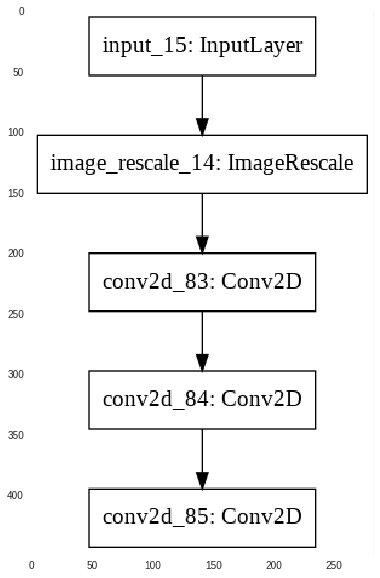

In [0]:
model4 = customModel4()
plot_model(model4, to_file='model4.png')
img=mpimg.imread('model4.png')
plt.figure(figsize=(10,10))
plt.grid(False)
plt.imshow(img)
del model4

In [0]:
session4 = tf.Session()
with session4.as_default():
  K.set_session(session4)
  model_new = load_model('gdrive/My Drive/model4.1.h5',{'ImageRescale':ImageRescale, 'psnr':psnr, 'DSSIMObjective':DSSIMObjective()})
  #model_new = customModel4()
  TrainModelFor(100,model_new,'model4.1',0.001,False,True)
  K.clear_session()
session4.close()
del model_new

Output hidden; open in https://colab.research.google.com to view.

<font size = "3pt">Very interesting. After the 27th epoch the gradient probably exploded and it reversed all of the progress made. Later it did it two more times with each next one having a lesser impact than the one before it(probably because of some kind of decay of the learning rate or something). I let it run for another 100 epochs to see if it will do better with a lower learning rate. It must be noted that in the original paper they used an extremely small dataset - only 90 images or so - therefore the model should definitely underperform here with a dataset of over a 100000 thousand images.</font>

In [0]:
session4 = tf.Session()
with session4.as_default():
  K.set_session(session4)
  model_new = load_model('gdrive/My Drive/model4.1.h5',{'ImageRescale':ImageRescale, 'psnr':psnr, 'DSSIMObjective':DSSIMObjective()})
  #model_new = customModel4()
  History = TrainModelFor(100,model_new,'model4.1',0.0003,False,True)
  K.clear_session()
session4.close()
del model_new

Output hidden; open in https://colab.research.google.com to view.

<font size="3">More sudden spikes in the training but they were not as severe and could be attributed to minibatch training (the batch size was only 64 after all).</font>

# Comparison
<font size="3">Now that I have accumulated a few models, it's time to test them and see which one performs the best.<font>

[INFO] loading batch 1 ...
(10000, 48, 48, 3)
(10000, 96, 96, 3)
shape:  [None, 48, 48, 3]
7951/7951 [==============================] - 15s 2ms/step
shape:  [None, 48, 48, 3]
7951/7951 [==============================] - 10s 1ms/step
shape:  [None, 48, 48, 3]
7951/7951 [==============================] - 35s 4ms/step
shape:  [None, 48, 48, 3]
7951/7951 [==============================] - 67s 8ms/step
shape:  [None, 48, 48, 3]
7951/7951 [==============================] - 8s 972us/step


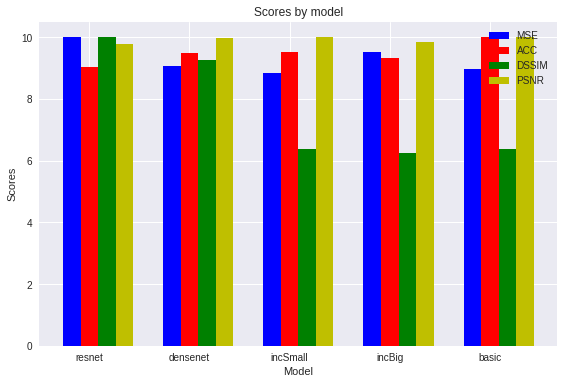

In [0]:
testX, testY = getBatch(0, False)
session_test = tf.Session()
print(testX.shape)
print(testY.shape)

with session_test.as_default():
  opt = Adam(lr=0.0) #I wont be using it but I need it to compile the models.
  K.set_session(session_test)
  model_resnet = load_model('gdrive/My Drive/model1.0.h5',{'ImageRescale':ImageRescale, 'psnr':psnr, 'DSSIMObjective':DSSIMObjective()})
  model_resnet.compile(loss=tf.losses.mean_squared_error, optimizer=opt, metrics=["accuracy", DSSIMObjective(), psnr])
  model_resnet.trainable=False
  scores_resnet = model_resnet.evaluate(testX[2048:-1], testY[2048:-1], batch_size=64, verbose=1)
  del model_resnet
  
  model_densenet = load_model('gdrive/My Drive/model2.2.h5',{'ImageRescale':ImageRescale, 'psnr':psnr, 'DSSIMObjective':DSSIMObjective()})
  model_densenet.compile(loss=tf.losses.mean_squared_error, optimizer=opt, metrics=["accuracy", DSSIMObjective(), psnr])
  model_densenet.trainable=False
  scores_densenet = model_densenet.evaluate(testX[2048:-1], testY[2048:-1], batch_size=64, verbose=1)
  del model_densenet
  
  model_inceptionSmall = load_model('gdrive/My Drive/model3.1.h5',{'ImageRescale':ImageRescale, 'psnr':psnr, 'DSSIMObjective':DSSIMObjective()})
  model_inceptionSmall.compile(loss=tf.losses.mean_squared_error, optimizer=opt, metrics=["accuracy", DSSIMObjective(), psnr])
  model_inceptionSmall.trainable=False
  scores_inceptionSmall = model_inceptionSmall.evaluate(testX[2048:-1], testY[2048:-1], batch_size=64, verbose=1)
  del model_inceptionSmall
  
  model_inceptionBig = load_model('gdrive/My Drive/model3.2.h5',{'ImageRescale':ImageRescale, 'psnr':psnr, 'DSSIMObjective':DSSIMObjective()})
  model_inceptionBig.compile(loss=tf.losses.mean_squared_error, optimizer=opt, metrics=["accuracy", DSSIMObjective(), psnr])
  model_inceptionBig.trainable=False
  scores_inceptionBig = model_inceptionBig.evaluate(testX[2048:-1], testY[2048:-1], batch_size=64,verbose=1)
  del model_inceptionBig
  
  model_basic = load_model('gdrive/My Drive/model4.1.h5',{'ImageRescale':ImageRescale, 'psnr':psnr, 'DSSIMObjective':DSSIMObjective()})
  model_basic.compile(loss=tf.losses.mean_squared_error, optimizer=opt, metrics=["accuracy", DSSIMObjective(), psnr])
  model_basic.trainable=False
  scores_basic = model_basic.evaluate(testX[2048:-1], testY[2048:-1], batch_size=64, verbose=1)
  del model_basic
  
  n_groups = 5

  MSE   = np.array([scores_resnet[0], scores_densenet[0], scores_inceptionSmall[0], scores_inceptionBig[0], scores_basic[0]])
  MSE *= (10.0/MSE.max())

  ACC   = np.array([scores_resnet[1], scores_densenet[1], scores_inceptionSmall[1], scores_inceptionBig[1], scores_basic[1]])
  ACC *= (10.0/ACC.max())
  
  DSSIM = np.array([scores_resnet[2], scores_densenet[2], scores_inceptionSmall[2], scores_inceptionBig[2], scores_basic[2]])
  DSSIM *= (10.0/DSSIM.max())
  
  PSNR  = np.array([scores_resnet[3], scores_densenet[3], scores_inceptionSmall[3], scores_inceptionBig[3], scores_basic[3]])
  PSNR *= (10.0/PSNR.min())
  
  fig, ax = plt.subplots()

  index = np.arange(n_groups)*2
  bar_width = 0.35

  opacity = 1.0

  rects1 = ax.bar(index, MSE, bar_width,
                  alpha=opacity, color='b',
                  label='MSE')

  rects2 = ax.bar(index + bar_width, ACC, bar_width,
                  alpha=opacity, color='r',
                  label='ACC')
  
  rects3 = ax.bar(index + bar_width*2, DSSIM, bar_width,
                  alpha=opacity, color='g',
                  label='DSSIM')
  
  rects4 = ax.bar(index + bar_width*3, PSNR, bar_width,
                  alpha=opacity, color='y',
                  label='PSNR')

  ax.set_xlabel('Model')
  ax.set_ylabel('Scores')
  ax.set_title('Scores by model')
  ax.set_xticks(index + bar_width)
  ax.set_xticklabels(('resnet', 'densenet', 'incSmall', 'incBig', 'basic'))
  ax.legend()

  fig.tight_layout()
  plt.show()
  K.clear_session()
session_test.close()

# Conclusion
<font size="3">In the end the small inception model performed the best on the PSNR scale with the basic SRCNN coming a close second. It should not come as a surprise as the other models are either a little weak or too complicated to be trained on such a small dataset and for such a small amount of time. For reference the basic model was trained for 200 generations, only about 2 and a half hours, while the inception model was trained for only about 100 generations which took some 6-7 hours, which means it could in theory be improved a lot. As for the big inception model it was trained for even fewer generations because it was so slow. The first two models came as a little of a surprise for me. They were supposed to be an improved version of basic SRCNN but they performed worse. I suspect the main culprit here was either the batch normalization or the learning rate.</font>
<h1>Things left to try</h1>
<font size="3">

*    I still haven't examined the possibility of a recurrent generative model like <a href="https://arxiv.org/pdf/1601.06759.pdf">pixelRNN</a> which might work here if for every generated pixel we give it the low-resolution pixel and the already accumulated information of previous activations.(Although as we discussed in the 4th lecture, CNNs are better at those tasks as they already see the surrounding pixels).<br/>
Definitely a bigger dataset.
*   Bigger dataset like imagenet

*   <a href='https://github.com/titu1994/Image-Super-Resolution'>DDSRCNN</a> which is the current best denoising algorithm there is. It's a deep residual convolutional net which takes input and outputs a clearer image.
*   <a href='https://arxiv.org/pdf/1609.04802.pdf'>SRGAN</a> because GANs are all the rage lately.




